<a href="https://www.kaggle.com/code/uurdemirkaya/quality-prediction-with-different-classification?scriptVersionId=165696076" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/apple-quality/apple_quality.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import recall_score, precision_score, f1_score,accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

import warnings
warnings.simplefilter(action="ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 170)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
df = pd.read_csv('/kaggle/input/apple-quality/apple_quality.csv')

In [4]:
df.head()

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,0.00,-3.97,-2.51,5.35,-1.01,1.84,0.33,-0.491590483,good
1,1.00,-1.20,-2.84,3.66,1.59,0.85,0.87,-0.722809367,good
2,2.00,-0.29,-1.35,-1.74,-0.34,2.84,-0.04,2.621636473,bad
3,3.00,-0.66,-2.27,1.32,-0.10,3.64,-3.41,0.790723217,good
4,4.00,1.36,-1.30,-0.38,-0.55,3.03,-1.30,0.501984036,good


In [5]:
df.isnull().sum()

A_id           1
Size           1
Weight         1
Sweetness      1
Crunchiness    1
Juiciness      1
Ripeness       1
Acidity        0
Quality        1
dtype: int64

In [6]:
df.dropna(inplace=True)

In [7]:
df.isnull().sum()

A_id           0
Size           0
Weight         0
Sweetness      0
Crunchiness    0
Juiciness      0
Ripeness       0
Acidity        0
Quality        0
dtype: int64

In [8]:
df.duplicated().sum()

0

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   A_id         4000 non-null   float64
 1   Size         4000 non-null   float64
 2   Weight       4000 non-null   float64
 3   Sweetness    4000 non-null   float64
 4   Crunchiness  4000 non-null   float64
 5   Juiciness    4000 non-null   float64
 6   Ripeness     4000 non-null   float64
 7   Acidity      4000 non-null   object 
 8   Quality      4000 non-null   object 
dtypes: float64(7), object(2)
memory usage: 312.5+ KB


In [10]:
df['Quality'].unique()

array(['good', 'bad'], dtype=object)

In [11]:
# Object olan typeları float ve integer e dönüştüreceğiz.
# We will convert object types to float and integer.

df['Acidity'] = df['Acidity'].astype(float)

# good olan yer True yani '1' konur. 'bad' olan ise False olur böylelikle '0' olur.
# where 'good' is True, so '1' is put. where 'bad' is False, so '0' is put.
df['Quality'] = (df['Quality'] == 'good').astype(int) 

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   A_id         4000 non-null   float64
 1   Size         4000 non-null   float64
 2   Weight       4000 non-null   float64
 3   Sweetness    4000 non-null   float64
 4   Crunchiness  4000 non-null   float64
 5   Juiciness    4000 non-null   float64
 6   Ripeness     4000 non-null   float64
 7   Acidity      4000 non-null   float64
 8   Quality      4000 non-null   int64  
dtypes: float64(8), int64(1)
memory usage: 312.5 KB


In [13]:
df['Quality'].value_counts()

Quality
1    2004
0    1996
Name: count, dtype: int64

In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
A_id,4000.00,1999.50,1154.84,0.00,999.75,1999.50,2999.25,3999.00
Size,4000.00,-0.50,1.93,-7.15,-1.82,-0.51,0.81,6.41
Weight,4000.00,-0.99,1.60,-7.15,-2.01,-0.98,0.03,5.79
Sweetness,4000.00,-0.47,1.94,-6.89,-1.74,-0.50,0.80,6.37
Crunchiness,4000.00,0.99,1.40,-6.06,0.06,1.00,1.89,7.62
Juiciness,4000.00,0.51,1.93,-5.96,-0.80,0.53,1.84,7.36
Ripeness,4000.00,0.50,1.87,-5.86,-0.77,0.50,1.77,7.24
Acidity,4000.00,0.08,2.11,-7.01,-1.38,0.02,1.51,7.40
Quality,4000.00,0.50,0.50,0.00,0.00,1.00,1.00,1.00


In [15]:
df.columns

Index(['A_id', 'Size', 'Weight', 'Sweetness', 'Crunchiness', 'Juiciness', 'Ripeness', 'Acidity', 'Quality'], dtype='object')

In [16]:
df.drop(columns=['A_id'], inplace=True)

In [17]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Size,4000.00,-0.50,1.93,-7.15,-1.82,-0.51,0.81,6.41
Weight,4000.00,-0.99,1.60,-7.15,-2.01,-0.98,0.03,5.79
Sweetness,4000.00,-0.47,1.94,-6.89,-1.74,-0.50,0.80,6.37
Crunchiness,4000.00,0.99,1.40,-6.06,0.06,1.00,1.89,7.62
Juiciness,4000.00,0.51,1.93,-5.96,-0.80,0.53,1.84,7.36
Ripeness,4000.00,0.50,1.87,-5.86,-0.77,0.50,1.77,7.24
Acidity,4000.00,0.08,2.11,-7.01,-1.38,0.02,1.51,7.40
Quality,4000.00,0.50,0.50,0.00,0.00,1.00,1.00,1.00


In [18]:
df.head()

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,-3.97,-2.51,5.35,-1.01,1.84,0.33,-0.49,1
1,-1.20,-2.84,3.66,1.59,0.85,0.87,-0.72,1
2,-0.29,-1.35,-1.74,-0.34,2.84,-0.04,2.62,0
3,-0.66,-2.27,1.32,-0.10,3.64,-3.41,0.79,1
4,1.36,-1.30,-0.38,-0.55,3.03,-1.30,0.50,1


In [19]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [20]:
X.head()

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity
0,-3.97,-2.51,5.35,-1.01,1.84,0.33,-0.49
1,-1.20,-2.84,3.66,1.59,0.85,0.87,-0.72
2,-0.29,-1.35,-1.74,-0.34,2.84,-0.04,2.62
3,-0.66,-2.27,1.32,-0.10,3.64,-3.41,0.79
4,1.36,-1.30,-0.38,-0.55,3.03,-1.30,0.50


In [21]:
y.head()

0    1
1    1
2    0
3    1
4    1
Name: Quality, dtype: int64

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [23]:
scaler =StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [24]:
X_test

array([[ 1.86627099, -0.44605275, -1.64169322, ...,  0.00318291,
         0.62685362, -0.30173496],
       [ 1.00573868,  0.47105943,  0.20994923, ...,  0.18290215,
        -1.43093904,  0.88558406],
       [ 0.88492503,  0.29295747,  1.12998604, ..., -0.56267641,
        -0.97163297,  0.43699053],
       ...,
       [-0.18967329, -2.11788445,  1.57199717, ...,  1.37130664,
         0.48395493, -0.52565637],
       [-0.23039557,  0.50805619,  0.49064554, ..., -0.29785843,
         0.52013526, -1.04409607],
       [ 0.51235402, -0.45484399, -0.01413663, ...,  1.36740829,
        -0.08474571, -0.93935657]])

### Linear Regression

In [25]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [26]:
lr.coef_

array([[ 1.24668307,  0.41787882,  1.13684893,  0.03344432,  0.85475968,
        -0.23972876, -0.66666667]])

In [27]:
lr.intercept_

array([-0.03621811])

In [28]:
y_pred = lr.predict(X_test)

In [29]:
print('Accuracy','%.3f' % accuracy_score(y_test, y_pred))
print('Precision','%.3f' % precision_score(y_test, y_pred))
print('Recall','%.3f' % recall_score(y_test, y_pred))
print('F1 Score','%.3f' % f1_score(y_test, y_pred))

Accuracy 0.754
Precision 0.754
Recall 0.752
F1 Score 0.753


In [30]:
cm = metrics.confusion_matrix(y_test,y_pred, labels = lr.classes_)

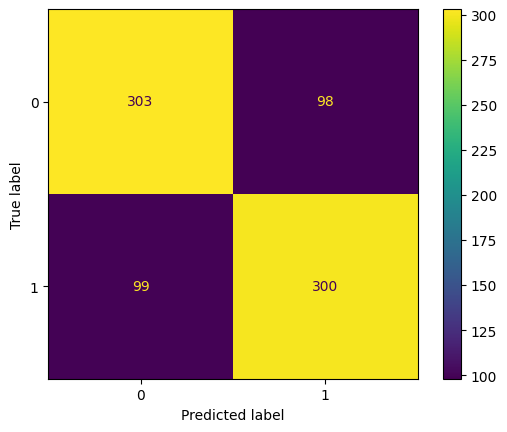

In [31]:
display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm,display_labels = lr.classes_)
display.plot();

In [32]:
for i in range(len(cm)):
    class_accuracy = cm[i, i] / cm[i, :].sum()
    print(f'Sınıf {i} için Accuracy: {class_accuracy:.3f}')

Sınıf 0 için Accuracy: 0.756
Sınıf 1 için Accuracy: 0.752


### Naive Bayes 

In [33]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

In [34]:
y_preds = gnb.predict(X_test)

print('Accuracy','%.3f' % accuracy_score(y_test, y_preds))
print('Precision','%.3f' % precision_score(y_test, y_preds))
print('Recall','%.3f' % recall_score(y_test, y_preds))
print('F1 Score','%.3f' % f1_score(y_test, y_preds))

Accuracy 0.762
Precision 0.770
Recall 0.747
F1 Score 0.758


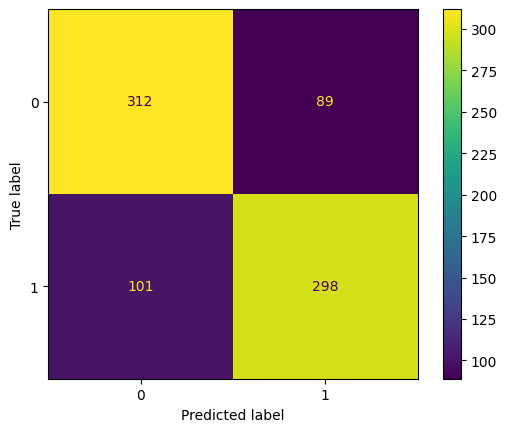

In [35]:
cm2 = metrics.confusion_matrix(y_test,y_preds, labels = gnb.classes_)

display2 = metrics.ConfusionMatrixDisplay(confusion_matrix = cm2,display_labels = gnb.classes_)
display2.plot();

In [36]:
for i in range(len(cm2)):
    class_accuracy = cm2[i, i] / cm2[i, :].sum()
    print(f'Sınıf {i} için Accuracy: {class_accuracy:.3f}')

Sınıf 0 için Accuracy: 0.778
Sınıf 1 için Accuracy: 0.747


### K-Nearest Neighbors (KNN)

In [37]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [38]:
y_pred_knn = knn.predict(X_test)

print('Accuracy','%.3f' % accuracy_score(y_test, y_pred_knn))
print('Precision','%.3f' % precision_score(y_test, y_pred_knn))
print('Recall','%.3f' % recall_score(y_test, y_pred_knn))
print('F1 Score','%.3f' % f1_score(y_test, y_pred_knn))

Accuracy 0.902
Precision 0.898
Recall 0.907
F1 Score 0.903


In [39]:
f1s = []
for i in range(1, 40):
    knnx = KNeighborsClassifier(n_neighbors=i)
    knnx.fit(X_train, y_train)
    pred_i = knnx.predict(X_test)
    f1s.append(f1_score(y_test, pred_i, average='weighted'))

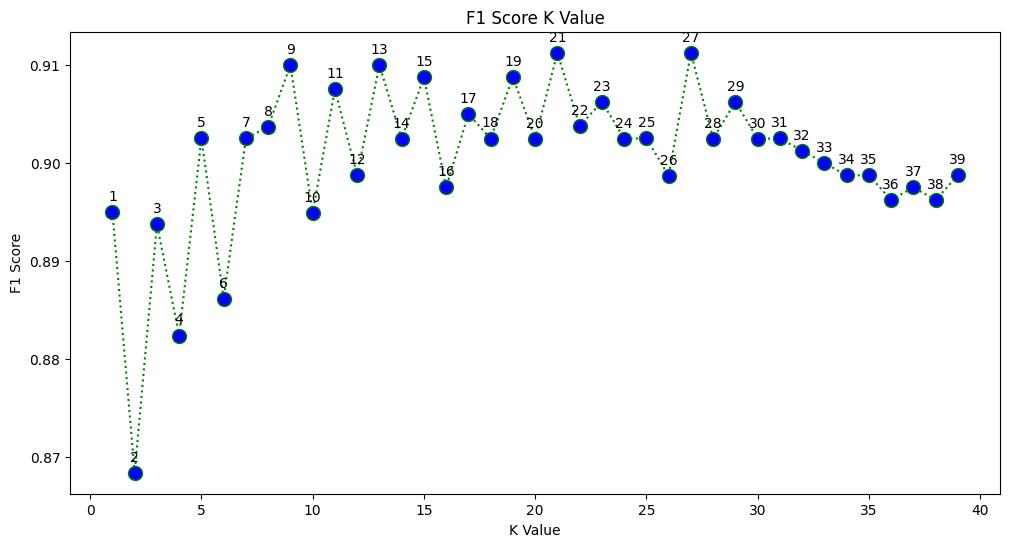

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), f1s,
         color='green',
         linestyle='dotted',
         marker='o',
         markerfacecolor='blue',
         markersize=10)

plt.title('F1 Score K Value')
plt.xlabel('K Value')
plt.ylabel('F1 Score')

for i, f1 in enumerate(f1s, start=1):
    plt.text(i, f1 + 0.0016, str(i), ha='center', va='center', fontsize=10)

In [41]:
knn_best = KNeighborsClassifier(n_neighbors=27)
knn_best.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=27)

In [42]:
y_pred_knn_best=knn_best.predict(X_test)

print('Accuracy','%.3f' % accuracy_score(y_test, y_pred_knn_best))
print('Precision','%.3f' % precision_score(y_test, y_pred_knn_best))
print('Recall','%.3f' % recall_score(y_test, y_pred_knn_best))
print('F1 Score','%.3f' % f1_score(y_test, y_pred_knn_best))

Accuracy 0.911
Precision 0.916
Recall 0.905
F1 Score 0.910


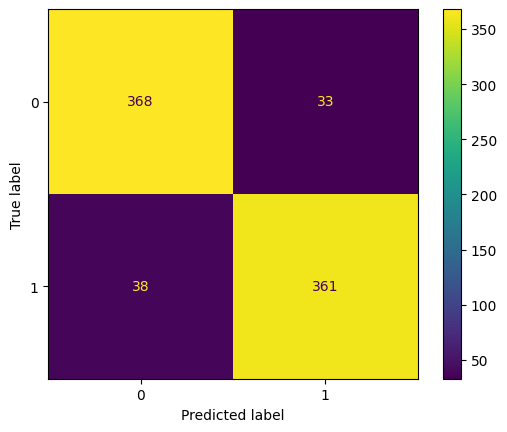

In [43]:
cm3 = metrics.confusion_matrix(y_test,y_pred_knn_best, labels = knn_best.classes_)

display3 = metrics.ConfusionMatrixDisplay(confusion_matrix = cm3,display_labels = knn_best.classes_)
display3.plot();

In [44]:
for i in range(len(cm3)):
    class_accuracy = cm3[i, i] / cm3[i, :].sum()
    print(f'Sınıf {i} için Accuracy: {class_accuracy:.3f}')

Sınıf 0 için Accuracy: 0.918
Sınıf 1 için Accuracy: 0.905


### Support Vector Machine

In [45]:
svc = SVC()
svc.fit(X_train, y_train)

SVC()

In [46]:
y_pred_svc = svc.predict(X_test)

print('Accuracy','%.3f' % accuracy_score(y_test, y_pred_svc))
print('Precision','%.3f' % precision_score(y_test, y_pred_svc))
print('Recall','%.3f' % recall_score(y_test, y_pred_svc))
print('F1 Score','%.3f' % f1_score(y_test, y_pred_svc))

Accuracy 0.904
Precision 0.905
Recall 0.902
F1 Score 0.903


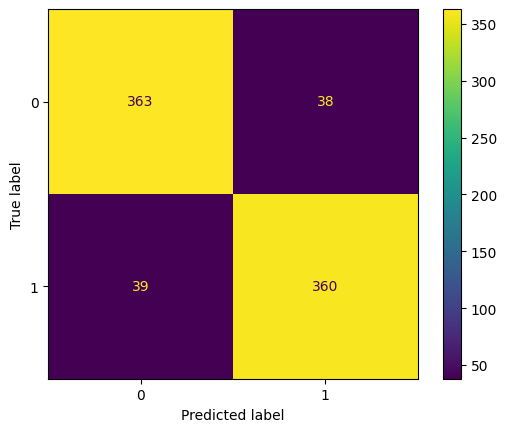

In [47]:
cm4 = metrics.confusion_matrix(y_test,y_pred_svc, labels = svc.classes_)

display4 = metrics.ConfusionMatrixDisplay(confusion_matrix = cm4,display_labels = svc.classes_)
display4.plot();

In [48]:
for i in range(len(cm4)):
    class_accuracy = cm4[i, i] / cm4[i, :].sum()
    print(f'Sınıf {i} için Accuracy: {class_accuracy:.3f}')

Sınıf 0 için Accuracy: 0.905
Sınıf 1 için Accuracy: 0.902


### Decision Tree

In [49]:
X_t_train, X_t_test, y_t_train, y_t_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [50]:
dtc = DecisionTreeClassifier()
dtc.fit(X_t_train, y_t_train)

DecisionTreeClassifier()

In [51]:
y_pred_dtc = dtc.predict(X_t_test)

print('Accuracy','%.3f' % accuracy_score(y_test, y_pred_dtc))
print('Precision','%.3f' % precision_score(y_test, y_pred_dtc))
print('Recall','%.3f' % recall_score(y_test, y_pred_dtc))
print('F1 Score','%.3f' % f1_score(y_test, y_pred_dtc))

Accuracy 0.806
Precision 0.800
Recall 0.815
F1 Score 0.807


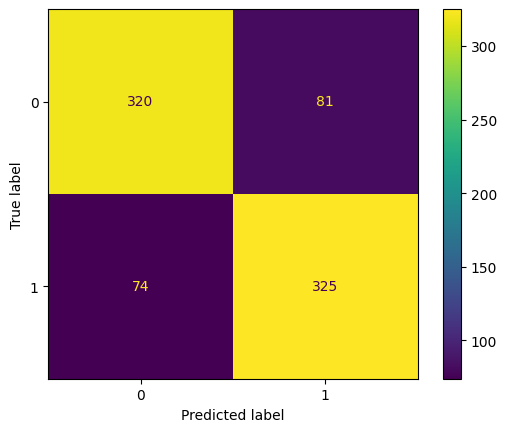

In [52]:
cm5 = metrics.confusion_matrix(y_test,y_pred_dtc, labels = dtc.classes_)

display5 = metrics.ConfusionMatrixDisplay(confusion_matrix = cm5,display_labels = dtc.classes_)
display5.plot();

In [53]:
for i in range(len(cm5)):
    class_accuracy = cm5[i, i] / cm5[i, :].sum()
    print(f'Sınıf {i} için Accuracy: {class_accuracy:.3f}')

Sınıf 0 için Accuracy: 0.798
Sınıf 1 için Accuracy: 0.815


### Random Forest

In [54]:
X_f_train, X_f_test, y_f_train, y_f_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [55]:
rfc = RandomForestClassifier()
rfc.fit(X_f_train,y_f_train)

RandomForestClassifier()

In [56]:
y_pred_rfc = rfc.predict(X_f_test)

print('Accuracy','%.3f' % accuracy_score(y_test, y_pred_dtc))
print('Precision','%.3f' % precision_score(y_test, y_pred_dtc))
print('Recall','%.3f' % recall_score(y_test, y_pred_dtc))
print('F1 Score','%.3f' % f1_score(y_test, y_pred_dtc))

Accuracy 0.806
Precision 0.800
Recall 0.815
F1 Score 0.807


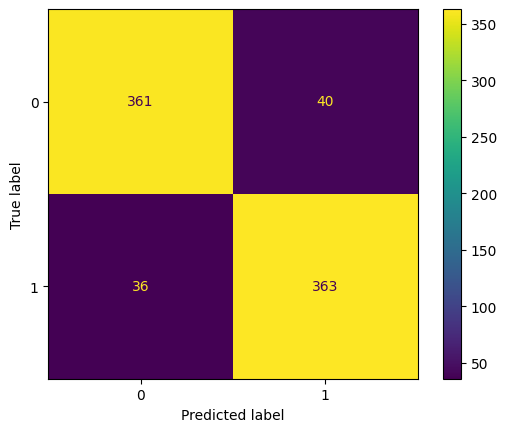

In [57]:
cm6 = metrics.confusion_matrix(y_test,y_pred_rfc, labels = rfc.classes_)

display6 = metrics.ConfusionMatrixDisplay(confusion_matrix = cm6,display_labels = rfc.classes_)
display6.plot();

In [58]:
for i in range(len(cm6)):
    class_accuracy = cm6[i, i] / cm6[i, :].sum()
    print(f'Sınıf {i} için Accuracy: {class_accuracy:.3f}')

Sınıf 0 için Accuracy: 0.900
Sınıf 1 için Accuracy: 0.910


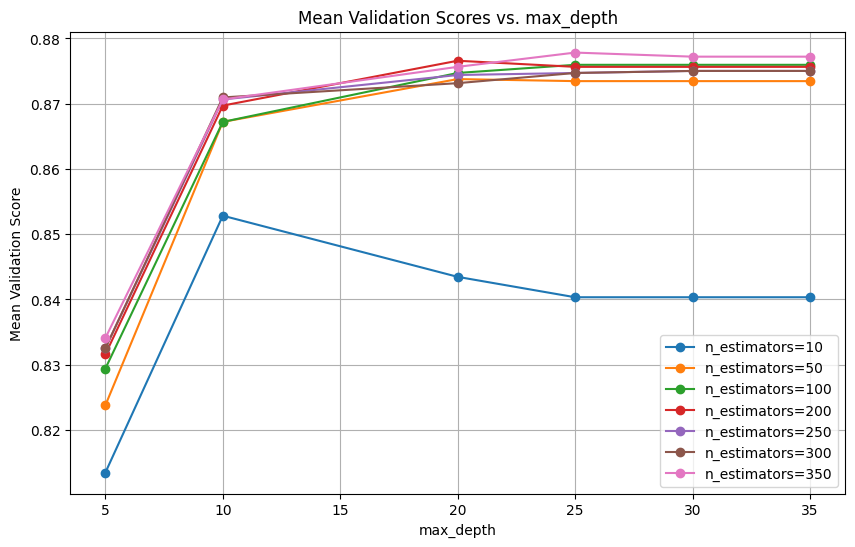

Best Parameters: {'max_depth': 25, 'n_estimators': 350}


In [59]:
param_grid = {
    'n_estimators': [10, 50, 100, 200,250,300,350],
    'max_depth': [None, 5, 10, 20,25,30,35]
}

#Create a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5)
grid_search.fit(X_f_train, y_f_train)

#Get the results of grid search
results_df = pd.DataFrame(grid_search.cv_results_)

#Plot mean validation scores for each combination of parameters
plt.figure(figsize=(10, 6))
for n_estimators in param_grid['n_estimators']:
    plt.plot(param_grid['max_depth'], results_df[results_df['param_n_estimators'] == n_estimators]['mean_test_score'],
             marker='o', label=f'n_estimators={n_estimators}')
plt.title('Mean Validation Scores vs. max_depth')
plt.xlabel('max_depth')
plt.ylabel('Mean Validation Score')
plt.legend()
plt.grid(True)
plt.show()

#Get the best combination of parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

In [60]:
rfc1= RandomForestClassifier(n_estimators=350,max_depth=20,random_state=0)
rfc1.fit(X_f_train,y_f_train)

RandomForestClassifier(max_depth=20, n_estimators=350, random_state=0)

In [61]:
y_pred_rfc1= rfc1.predict(X_f_test)

print('Accuracy','%.3f' % accuracy_score(y_test, y_pred_rfc1))
print('Precision','%.3f' % precision_score(y_test, y_pred_rfc1))
print('Recall','%.3f' % recall_score(y_test, y_pred_rfc1))
print('F1 Score','%.3f' % f1_score(y_test, y_pred_rfc1))

Accuracy 0.911
Precision 0.904
Recall 0.920
F1 Score 0.912


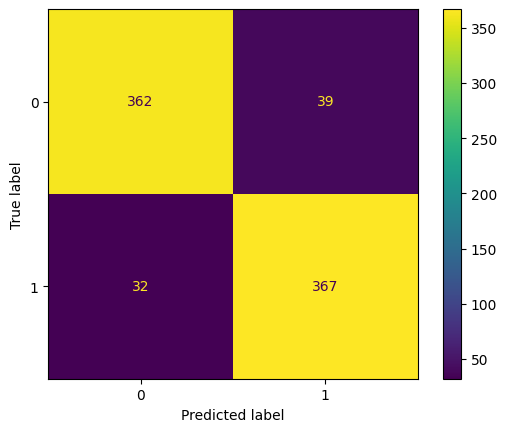

In [62]:
cm7 = metrics.confusion_matrix(y_test,y_pred_rfc1, labels = rfc1.classes_)

display7 = metrics.ConfusionMatrixDisplay(confusion_matrix = cm7,display_labels = rfc1.classes_)
display7.plot();

In [63]:
for i in range(len(cm7)):
    class_accuracy = cm7[i, i] / cm7[i, :].sum()
    print(f'Sınıf {i} için Accuracy: {class_accuracy:.3f}')

Sınıf 0 için Accuracy: 0.903
Sınıf 1 için Accuracy: 0.920


#### Linear regression 

Sınıf 0 için Accuracy: 0.756
Sınıf 1 için Accuracy: 0.752

#### Naive Bayes

Sınıf 0 için Accuracy: 0.778
Sınıf 1 için Accuracy: 0.747

#### KNN

Sınıf 0 için Accuracy: 0.915
Sınıf 1 için Accuracy: 0.897

#### SVC 

Sınıf 0 için Accuracy: 0.905
Sınıf 1 için Accuracy: 0.902

#### Decision Tree

Sınıf 0 için Accuracy: 0.805
Sınıf 1 için Accuracy: 0.815

#### Random Forest

Sınıf 0 için Accuracy: 0.903
Sınıf 1 için Accuracy: 0.912

#### Random Forest best_params_

Sınıf 0 için Accuracy: 0.903
Sınıf 1 için Accuracy: 0.920